## <font color= darkblue> Statistical Models Application For Bitcoin Daily Direction Analysis</font>
\author{Agustin Muñoz Gonzalez} \date{July 2021}

\maketitle
\makeatletter
\renewcommand{\@seccntformat}[1]{}
\makeatother

In this project we will give an overview of several data-science models and their application to the binary classification problem of the future Bitcoin's price daily movement direction.

We will a set of different features that covered the following aspects:
\begin{itemize}
\item Price discovery phenomenon for Bitcoin;
\item Market sentiment;
\item Technical Indicators;
\item On-chain metrics.
\end{itemize}

The visited bibliography and previous works will be added at the end.

# <font color= darkblue> Part I: Exploratory Data Analysis & Engineering Data Features</font>


### <font color= darkblue>Financial Data Preprocessing, Feature Engineering and Feature Learning</font>

A time series is a series of data points indexed in time order. Financial Data such as bitcoin price series observed at equally spaced points in time are an example of such a series. It is a sequence of observations recorded at regular time intervals and depending on the frequency of observations, a time series may typically be in seconds, minute, hourly, daily, weekly, monthly, quarterly and annually. In Marcos Lopez de Prado words "Finance is not a plug-and-play subject as it relates to machine learning. Modelling financial series is harder than driving cars or recognizing faces."

The first step towards any data analysis would be to parse the raw data which involves extracting the data from the source and then cleansing and filling the missing data, if any. While data comes in many forms, Python makes it easy to read time series data using useful packages.

We use pandas-datareader library to retrieve historical data from investpy, a Python package for historical data extraction from cryptocurencies, funds, ETFs. 

### <font color= darkblue>Importing required libraries</font>
We initially import several python packages in order to view, explore, analyze, visualize results and measure performance speeds on the data. We also import additional modules from various subpackages of Keras that will be used for building the various neural networks and will be explained in more detail when encountered.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import math
import investpy
# Import preprocessor from sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Import from keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.layers import Dropout, Dense, LSTM

# Import cufflinks for visualization
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] =(20,10)
plt.style.use('fivethirtyeight')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# We set a seed value in order to be able of reproduce the results.
seed_value= 123
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
# 4. Set `tensorflow` pseudo-random generator at a fixed value
# import tensorflow as tf
# tf.set_random_seed(seed_value)

from numpy.random import seed
seed(123)

#### <font color= darkblue> Data Collection</font>
The work is based on data from Bitsamp (via quand.com), Investing.com and docs.coinmetrics.io. We have used daily historic data from February 23rd 2017 to March 15th 2021. Namely, about 1000 data.

In [2]:
Bitcoin=pd.read_csv('data/BITSTAMP-USD.csv', index_col=0, parse_dates=True).dropna()
Bitcoin = Bitcoin[::-1]

#### <font color= darkblue>Visualising Bitcoin Prices fluctations</font>

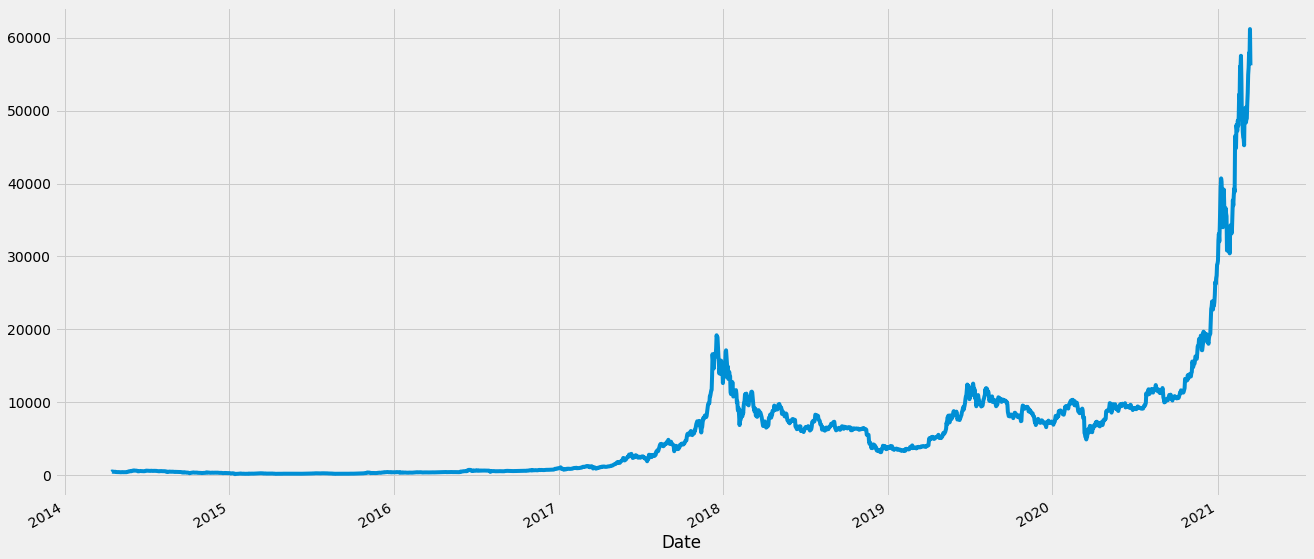

In [3]:
Bitcoin['Last'].plot(figsize=(20,10));

Given that it isn't clear which factors affect Bitcoin's price, we considered appropiated to cover 3 aspects:

\begin{itemize}
\item Closely related factors with Bitcoin's spot price such as: BTC's Futures and Ethereum's price;
\item Macro indicators: a few important commodities such as crude, 10 years treasury and VIX volatility index;
\item Technnical indicators linked with volume, momentum, volatily and BTC candlestick data;
\item On-chain metrics, i.e., Blockchain closely related metrics.
\end{itemize}

#### <font color= darkblue> Adding different types of features – Market Prediction with more Features</font>
<table>
<thead><tr>
<th style="text-align:left">Symbol</th>
<th style="text-align:left">Description</th>   
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left">CME_BitcoinFutures</td>
<td style="text-align:left">BTC's future contracts </td>   
</tr>    
<tr>    
<td style="text-align:left">ETH</td> 
<td style="text-align:left">Ethereum's closing price</td>    
</tr>      
<tr>     
<td style="text-align:left">CRUDE, Gold, Treasury_10</td>
<td style="text-align:left">Crude and Gold's futures, and 10 Years Treasury's closing price</td>     
</tr>    
<tr>       
<td style="text-align:left">SPY</td>
<td style="text-align:left">S\&P index's futures</td>       
</tr>    
<tr>      
<td style="text-align:left">ATR</td>
<td style="text-align:left">Average True Range (ATR): a BTC's volatility technnical indicator</td>       
</tr>    
<tr>     
<td style="text-align:left">OBV</td>
<td style="text-align:left">On-balance volume (OBV): a BTC's momentum technnical indicator that uses BTC's daily volume</td>     
</tr>    
<tr>       
<td style="text-align:left">sma14, sma60</td>
<td style="text-align:left">14 and 60 days BTC's moving averages</td>       
</tr>        
<tr>    
<td style="text-align:left">vol14, vol60</td>
<td style="text-align:left">14 and 60 days BTC's volatility</td>    
</tr>       
<tr>    
<td style="text-align:left">sma20,b_upper,b_lower</td>
<td style="text-align:left">BTC's Bollinger Bands: a technnical indicator associated with overbought and oversold</td>      
</tr>    
<tr>         
<td style="text-align:left">MOM5D, STD21</td>
<td style="text-align:left">5-days BTC's momentum, and 21-days BTC's standard deviation with respect to BTC's closing prices and BTC's daily returns, respectly</td> 
</tr> 
<tr>    
<td style="text-align:left">High, Low, Last, Bid, Ask </td>
<td style="text-align:left"> BTC's candlestick data</td>   
</tr>
<tr>     
<td style="text-align:left">Returns </td>
<td style="text-align:left"> BTC's daily returns</td>    
</tr>
<tr>     
<td style="text-align:left">MVRV_FF</td>
<td style="text-align:left"> COMPLETAR</td>    
</tr>
<tr>     
<td style="text-align:left">HashRate </td>
<td style="text-align:left"> COMPLETAR</td>    
</tr>
<tr>     
<td style="text-align:left">Miner_revenue </td>
<td style="text-align:left"> COMPLETAR</td>    
</tr>
<tr>    
</tbody>
</table>     


Definimos las funciones que usaremos para el cálculo de algunas de las features anteriores.

In [4]:
def ATR(df,n):
    "function to calculate True Range and Average True Range"
    df = df.copy() # we assume that df's order is increasing in dates

    df['H-L']  = abs(df['High']-df['Low'])
    df['H-PO'] = abs(df['High']-df['Open'].shift(1))
    df['L-PO'] = abs(df['Low']-df['Open'].shift(1))
    
    df['TR']   = df[['H-L','H-PO','L-PO']].max(axis=1,skipna=False)
    df['ATR']  = df['TR'].rolling(n).mean()

    df2 = df.drop(['H-L','H-PO','L-PO'],axis=1)
    return df2

def OBV(df):
	n=len(df)
	OBV=[]
	OBV.append(0)
	for i in range(0,n-1):
		if df['Price'][i]<df['Price'][i+1]:
			OBV.append(OBV[i]+df['Volume'][i+1])
		elif df['Price'][i]>df['Price'][i+1]:
			OBV.append(OBV[i]-df['Volume'][i+1])
	return OBV

# 'CME_BitcoinFutures' and 'ETH' data is expressed as string, so we have to convert it to float.
def text_currency_to_float(text):
  t = text
  dot_pos = t.rfind('.')
  comma_pos = t.rfind(',')
  if comma_pos > dot_pos:
    t = t.replace(".", "")
    t = t.replace(",", ".")
  else:
    t = t.replace(",", "")

  return(float(t))

Cargamos los demás datos necesarios.

In [7]:
#DXY
DXY=pd.read_csv('data/US Dollar Index Historical Data.csv', index_col=0, parse_dates=True).dropna()
DXY=DXY.rename(columns={'Price':'Close'})

# Delete data rows with nan values
DXY=DXY.dropna() 
DXY=DXY[::-1] # We let it ordered decresently

# Otras
EUR_JPY=pd.read_csv('data/EUR_JPY Historical Data.csv', index_col=0, parse_dates=True).dropna()['Price']
GBP_CAD=pd.read_csv('data/GBP_CAD Historical Data.csv', index_col=0, parse_dates=True).dropna()['Price']
AUD_CHF=pd.read_csv('data/AUD_CHF Historical Data.csv', index_col=0, parse_dates=True).dropna()['Price']
CRUDE=pd.read_csv('data/Crude Oil WTI Futures Historical Data.csv', index_col=0, parse_dates=True).dropna()['Price']
Treasury_10=pd.read_csv('data/United States 10-Year Bond Yield Historical Data.csv', index_col=0, parse_dates=True).dropna()['Price']
SPY=pd.read_csv('data/SPY Historical Data.csv', index_col=0, parse_dates=True).dropna()['Price']

# GOLD
GOLD=pd.read_csv('data/Gold Futures Historical Data.csv', index_col=0, parse_dates=True, thousands=',').dropna()
GOLD=Gold[::-1]

Procedemos a armar el dataframe con todos las features y la muestra de datos por un lado, y un dataframe con la variable respuesta correspondiente por otro.

In [9]:
# BTC's returns
rt_Bitcoin=np.around(Bitcoin['Last'].pct_change().dropna(),3)#.reindex(index=rt_BBAR.index[::-1])
# We suit dimensions
Bitcoin=Bitcoin.rename(columns={'Last':'Open'}) # ATR uses 'Open' so we have to rename 'Last'
ATR_Bitcoin = ATR(Bitcoin,21)['ATR']
Bitcoin=Bitcoin.rename(columns={'Open':'Last'}) # We change it to 'Last' again
Bitcoin['Returns']=rt_Bitcoin
Bitcoin['ATR']=ATR_Bitcoin
Bitcoin['OBV']=OBV(Bitcoin[::-1].rename(columns={'Last':'Price'}))[::-1] # OBV uses 'Price' so we change it

# BTC's spot price related Indicators
Bitcoin['CME_BitcoinFutures']=pd.read_csv('data/Bitcoin Futures CME Historical Data.csv', index_col=0, parse_dates=True).dropna()['Price']
Bitcoin['ETH']=pd.read_csv('data/Ethereum Historical Data.csv', index_col=0, parse_dates=True).dropna()['Price']

# Macro Indicators
Bitcoin['CRUDE']=CRUDE
#Bitcoin['Gold']=GOLD
Bitcoin['Treasury_10']=Treasury_10
Bitcoin['SPY']=SPY

# Technnical Indicators
# Simple Moving Averages
# 2 week
Bitcoin['sma14'] = Bitcoin['Last'].rolling(14).mean()
# 2 month
Bitcoin['sma60'] = Bitcoin['Last'].rolling(60).mean()

# Rolling Volatility (annualized assuming 365 trading days)
# 2 week
Bitcoin['vol14'] = Bitcoin['Returns'].rolling(14).std() * np.sqrt(365)
# 2 month
Bitcoin['vol60'] = Bitcoin['Returns'].rolling(60).std() * np.sqrt(365)


# Bollinger Bands
# 20 day simple moving average
Bitcoin['sma20'] = Bitcoin['Last'].rolling(20).mean()
# Upper band
Bitcoin['b_upper'] = Bitcoin['sma20'] + 2 * Bitcoin['sma20'].rolling(20).std()
# Lower band
Bitcoin['b_lower'] = Bitcoin['sma20'] - 2 * Bitcoin['sma20'].rolling(20).std()


MOM5D=np.around([Bitcoin['Last'][t]-Bitcoin['Last'][t-5] for t in range(5,len(Bitcoin['Last']))],3)
STD21D=np.around([np.std(rt_Bitcoin[::-1][t:t+21]) for t in range(0,len(rt_Bitcoin)-21)],3)[::-1]
# For these features we have to reduce the sample size due to min{len(MOM5D),len(STD21D)}<len(Bitcoin)
N=len(STD21D)
Bitcoin=Bitcoin[::-1].iloc[range(0,N)] 
Bitcoin=Bitcoin[::-1] 
Bitcoin['MOM5D']=MOM5D[::-1][0:N][::-1] 
Bitcoin['STD 21D']=STD21D

# On-chain metrics
on_chain_metrics=pd.read_csv('data/btc.csv', index_col=0, parse_dates=True).dropna()
Bitcoin['MVRV_FF']=on_chain_metrics['CapMVRVFF']
Bitcoin['HashRate']=on_chain_metrics['HashRate']
Bitcoin['Miner_revenue']=on_chain_metrics['RevUSD']

# We drop features we won't use
Bitcoin.drop('Volume',axis=1,inplace=True)
Bitcoin.drop('VWAP',axis=1,inplace=True)

# We drop NANs
Bitcoin=Bitcoin.dropna()
Bitcoin=Bitcoin[::-1] # We let it ordered decresently

# We transform string value to float
n_1=len(Bitcoin['CME_BitcoinFutures'])
n_2=len(Bitcoin['ETH'])
for i in range(0,n_1):
	Bitcoin['CME_BitcoinFutures'][i]=text_currency_to_float(Bitcoin['CME_BitcoinFutures'][i])
for i in range(0,n_2):
	Bitcoin['ETH'][i]=text_currency_to_float(Bitcoin['ETH'][i])

In [27]:
X=Bitcoin

# Our response feature will be the sign of BTC's returns (i.e. movement direction)
Y=pd.DataFrame({
	'Sign': np.sign(X['Returns'])})
# We transform 0's into 1's in order to work with a binary classification problem
for i in range(len(Y['Sign'])):
	if Y['Sign'][i]==0:
		Y['Sign'][i]=1

In [11]:
list(Bitcoin.keys())

['High',
 'Low',
 'Last',
 'Bid',
 'Ask',
 'Returns',
 'ATR',
 'OBV',
 'CME_BitcoinFutures',
 'ETH',
 'CRUDE',
 'Treasury_10',
 'SPY',
 'sma14',
 'sma60',
 'vol14',
 'vol60',
 'sma20',
 'b_upper',
 'b_lower',
 'MOM5D',
 'STD 21D',
 'MVRV_FF',
 'HashRate',
 'Miner_revenue']

In [12]:
X.head(), Y.head()

(                High       Low      Last       Bid       Ask  Returns  \
 Date                                                                    
 2021-03-15  60748.78  54555.00  56196.91  56174.41  56188.70   -0.081   
 2021-03-12  58155.99  54269.00  57881.67  57847.33  57877.59    0.036   
 2021-03-11  57402.89  53010.00  55853.90  55914.60  55920.20    0.017   
 2021-03-10  54939.26  51857.00  54927.29  54901.04  54927.49    0.048   
 2021-03-09  52427.91  49316.98  52427.91  52432.31  52439.00    0.028   
 
                     ATR          OBV CME_BitcoinFutures      ETH  ...  \
 Date                                                              ...   
 2021-03-15  4530.447619     0.000000              56900  1792.38  ...   
 2021-03-12  4375.560000  7593.458385              57075   1766.9  ...   
 2021-03-11  4271.292381   674.097023              57955  1825.79  ...   
 2021-03-10  4240.383810 -4753.680697              56620  1794.14  ...   
 2021-03-09  4263.443333 -9174.22751

In [13]:
# We escalate the data in order to perform the feature selection methods
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)


# We let X as a dataframe
X=pd.DataFrame(scaled_X,columns=list(Bitcoin.keys()))  

## Feature Selection

Feature selection methods are intended to reduce the number of input variables to those that are believed to be most useful to a model.

We have to do a distinction between the kind of analysis we are pursuing, being them: a descriptive analysis, a explanatory analysis or a predictive analysis.

A descriptive analysis involves simply stating the facts as they are. A descriptive analysis should not at any point provide any conclusions or generalizations. At most a descriptive analysis may involved providing summaries, descriptive statistics such as means, standard deviations, and graphs and visualizations to better understand the data. We are looking for the "what".

An explanatory analysis will try not only to describe the information but also to provide causal relationships between the various data presented. When we're dealing with quantitative and statistical data an explanatory analysis will provide some mathematical models tying the variables together which explain the influence they have on each other. You no longer just describe the facts, you also describe the cause and effect relationship between the facts. You are looking for the "why".

The predictive analysis is just going one step further than the explanatory analysis and applying the relationships of mathematical models that were discovered to previously unknown data and future cases. Take into account that the predictive analysis won't necessarily involve the same features than in the explicative analysis, but even a few less. You are looking for the "what if".

Next, we will use two feature selection methods mainly used in explanatory analysis. Although we want to perform a predictive analysis, it could be useful to se how explanatory the features are and which of them are the most explanatorys.

#### SelectKBest (For classification: f_classif, )
The SelectKBest class just scores the features using a function (in this case f_classif but could be others) and then "removes all but the k highest scoring features". The f_classif function ANOVA F-value between label/feature for classification tasks. 

ANOVA is an acronym for “analysis of variance” and is a parametric statistical hypothesis test for determining whether the means from two or more samples of data (often three or more) come from the same distribution or not.

An F-statistic, or F-test, is a class of statistical tests that calculate the ratio between variances values, such as the variance from two different samples or the explained and unexplained variance by a statistical test, like ANOVA. The ANOVA method is a type of F-statistic referred to here as an ANOVA f-test.

In [28]:
# feature selection
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
# We apply SelectKBest class to order the most relevant features with respect to f_classif
bestfeatures = SelectKBest(score_func=f_classif, k=len(X.keys()))
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
# we concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(len(X.keys()),'Score'))  #print 10 best features

                 Specs       Score
5              Returns  890.526829
20               MOM5D   54.597695
22             MVRV_FF   13.104378
10               CRUDE    1.843723
7                  OBV    1.087757
14               sma60    0.834043
11         Treasury_10    0.791836
21             STD 21D    0.673978
6                  ATR    0.609570
15               vol14    0.592126
18             b_upper    0.434973
17               sma20    0.379058
16               vol60    0.370301
13               sma14    0.339373
19             b_lower    0.303481
23            HashRate    0.282368
3                  Bid    0.245523
2                 Last    0.244707
4                  Ask    0.244136
9                  ETH    0.151103
12                 SPY    0.036414
1                  Low    0.009375
8   CME_BitcoinFutures    0.005251
0                 High    0.003658
24       Miner_revenue    0.000112


#### ExtraTreesClassifier
##### Decision Tree (High Variance)
A single decision tree is usually overfits the data it is learning from because it learn from only one pathway of decisions. Predictions from a single decision tree usually don’t make accurate predictions on new data.

###### Random Forest (Medium Variance)
Random forest models reduce the risk of overfitting by introducing randomness by:
\begin{itemize}
\item building multiple trees (n_estimators);
\item drawing observations with replacement (i.e., a bootstrapped sample);
\item splitting nodes on the best split among a random subset of the features selected at every node.
\end{itemize}

##### Extremely Randomized Trees (or Extra Trees for short)
Is an ensemble machine learning algorithm.

Specifically, it is an ensemble of decision trees and is related to other ensembles of decision trees algorithms such as bootstrap aggregation (bagging) and random forest.

This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. Bagged decision trees like Extra Trees can be used to estimate the importance of features. 

[0.02383738 0.02237205 0.02294464 0.02365036 0.02437701 0.41305006
 0.02270036 0.02785494 0.02082751 0.02330461 0.02420058 0.02414569
 0.02196195 0.02119359 0.0195518  0.023756   0.02128334 0.02001649
 0.02153889 0.02107729 0.05041215 0.0233941  0.02776572 0.02761799
 0.0271655 ]


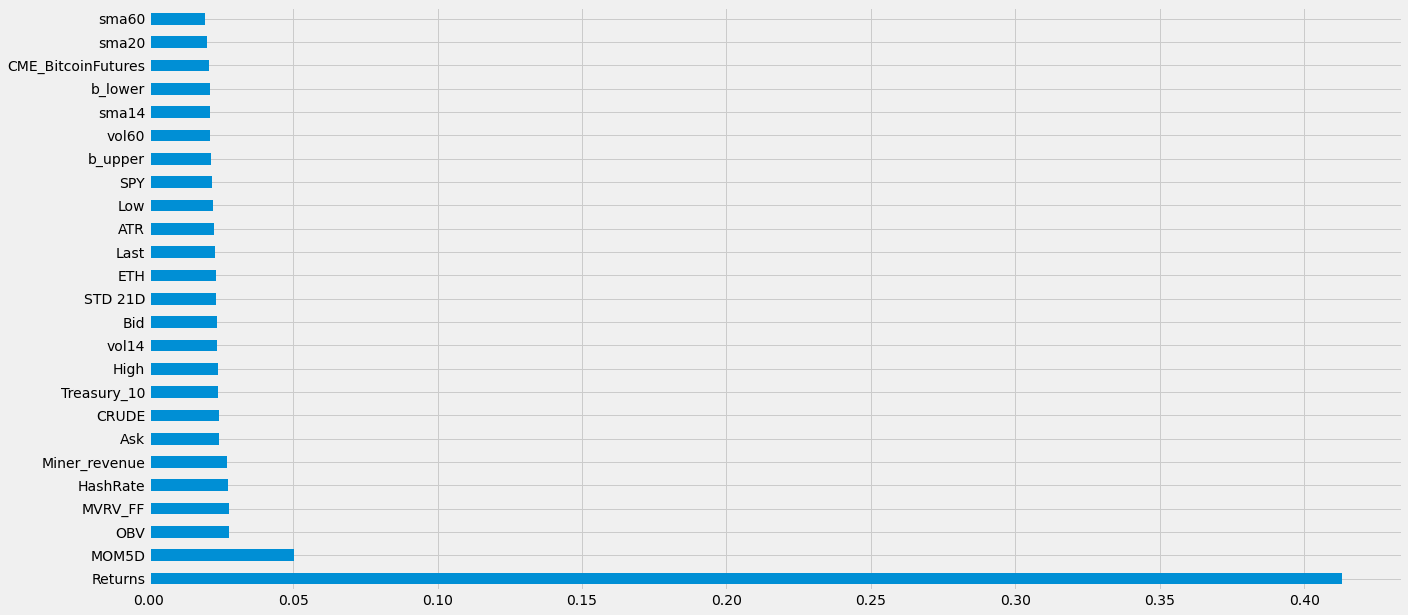

In [29]:
# FEATURE IMPORTANCE
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,Y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(len(X.keys())).plot(kind='barh')
plt.show()

#### Model selection with Probabilistic PCA and Factor Analysis (FA)

Probabilistic PCA and Factor Analysis are probabilistic models. The consequence is that the likelihood of new data can be used for model selection. Here we compare PCA and FA with cross-validation

best n_components by PCA CV = 15
best n_components by FactorAnalysis CV = 0
best n_components by PCA MLE = 24


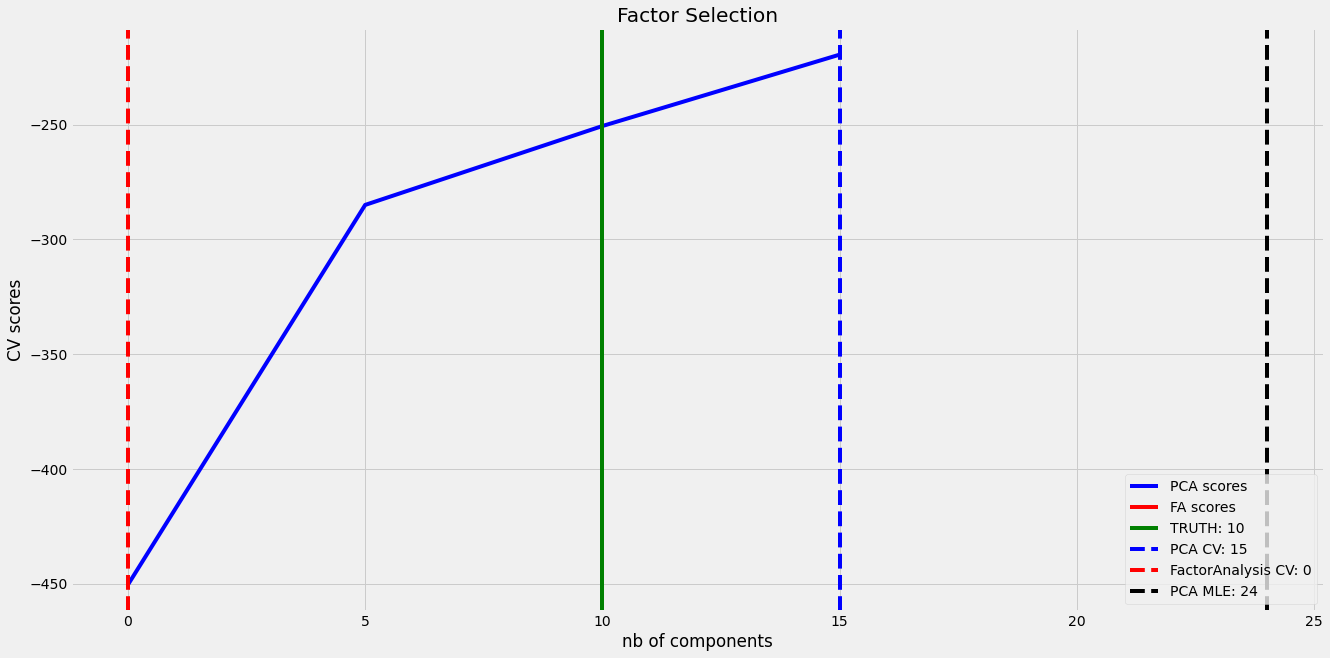

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA, FactorAnalysis
n_samples, n_features, rank = len(X), len(list(X.keys())), 10
n_components = np.arange(0, len(list(X.keys())), 5)
def compute_scores(X):
    pca = PCA(svd_solver='full')
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))

    return pca_scores, fa_scores
pca_scores, fa_scores = compute_scores(X)
n_components_pca = n_components[np.argmax(pca_scores)]
n_components_fa = n_components[np.argmax(fa_scores)]
pca = PCA(svd_solver='full', n_components='mle')
pca.fit(X)
n_components_pca_mle = pca.n_components_

print("best n_components by PCA CV = %d" % n_components_pca)
print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
print("best n_components by PCA MLE = %d" % n_components_pca_mle)

plt.figure()
plt.plot(n_components, pca_scores, 'b', label='PCA scores')
plt.plot(n_components, fa_scores, 'r', label='FA scores')
plt.axvline(rank, color='g', label='TRUTH: %d' % rank, linestyle='-')
plt.axvline(n_components_pca, color='b',
                label='PCA CV: %d' % n_components_pca, linestyle='--')
plt.axvline(n_components_fa, color='r',
                label='FactorAnalysis CV: %d' % n_components_fa,
                linestyle='--')
plt.axvline(n_components_pca_mle, color='k',
                label='PCA MLE: %d' % n_components_pca_mle, linestyle='--')
plt.xlabel('nb of components')
plt.ylabel('CV scores')
plt.legend(loc='lower right')
plt.title('Factor Selection')
plt.show()

In [17]:
fa_scores, pca_scores
n_components

array([ 0,  5, 10, 15, 20])

In [18]:
X_=pca.fit_transform(X)
X_

array([[ 3.01197079e+00,  8.58086298e-01, -5.80902332e-01, ...,
        -2.49572368e-03, -1.55533774e-04, -2.56572625e-04],
       [ 3.00990086e+00,  8.24847285e-01, -6.18737353e-01, ...,
         3.17209567e-03, -2.98004968e-04,  6.98887004e-06],
       [ 2.92534833e+00,  8.47623165e-01, -5.79590883e-01, ...,
         2.11188927e-02,  8.92353372e-04,  4.41929855e-05],
       ...,
       [-8.78357809e-01,  7.65694729e-02, -9.34068035e-02, ...,
        -2.20992253e-05, -1.60438513e-06,  7.23468830e-06],
       [-8.69761566e-01,  5.98430324e-02, -8.57094803e-02, ...,
         5.34322901e-04, -2.60710099e-05,  8.71956799e-06],
       [-8.79324289e-01,  7.89093025e-02, -9.27118274e-02, ...,
        -1.83772361e-04,  1.98329178e-05,  5.95261020e-06]])

In [19]:
Y_=pd.DataFrame(X_)
Y_

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,3.011971,0.858086,-0.580902,0.135710,0.141946,-0.264250,0.002538,-0.195575,-0.066313,-0.073765,...,-0.045403,0.068179,-0.074407,0.108825,0.067879,0.000946,0.032133,-0.002496,-0.000156,-0.000257
1,3.009901,0.824847,-0.618737,0.231913,0.142465,0.010118,0.300168,-0.195141,-0.235605,-0.111690,...,0.084402,0.094018,-0.011680,0.046171,0.003020,-0.000965,-0.016476,0.003172,-0.000298,0.000007
2,2.925348,0.847623,-0.579591,0.245875,0.146767,-0.071571,0.242870,-0.138120,-0.178407,-0.087703,...,0.045278,0.074885,-0.047748,0.014967,-0.007904,-0.001831,-0.003574,0.021119,0.000892,0.000044
3,2.924804,0.810350,-0.536414,0.210187,0.137606,-0.032413,0.262815,-0.160682,-0.129259,-0.055528,...,0.047654,0.085728,-0.029029,0.005457,-0.022521,-0.008937,-0.021535,0.016208,-0.000197,0.000007
4,2.825325,0.823783,-0.499862,0.164480,0.137539,-0.162800,0.151804,-0.110595,0.028750,0.017466,...,-0.001753,0.063555,-0.050368,0.003734,-0.011916,-0.007132,-0.031230,0.023739,0.000155,-0.000164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,-0.880505,0.089666,-0.115849,0.483818,0.079717,-0.149326,0.043595,-0.025070,0.004533,-0.071248,...,-0.001169,-0.010375,-0.011188,-0.008151,0.008051,-0.000028,-0.000441,-0.000317,0.000024,0.000011
994,-0.880753,0.078760,-0.102514,0.482278,0.088049,-0.141505,0.072473,-0.035956,0.016870,-0.054909,...,-0.006491,-0.013769,-0.008675,-0.006319,0.006627,-0.000454,0.000491,-0.000229,0.000015,-0.000009
995,-0.878358,0.076569,-0.093407,0.490347,0.083174,-0.132856,0.089038,-0.029828,0.031011,-0.052609,...,-0.009062,-0.013798,-0.008831,-0.006201,0.006961,-0.000442,0.001261,-0.000022,-0.000002,0.000007
996,-0.869762,0.059843,-0.085709,0.496478,0.097348,-0.100068,0.121758,-0.028226,0.056995,-0.046472,...,-0.013173,-0.014170,-0.008709,-0.005980,0.006067,-0.000614,0.003061,0.000534,-0.000026,0.000009


In [20]:
X

,High,Low,Last,Bid,Ask,Returns,ATR,OBV,CME_BitcoinFutures,ETH,...,vol14,vol60,sma20,b_upper,b_lower,MOM5D,STD 21D,MVRV_FF,HashRate,Miner_revenue
0,1.000000,0.982002,0.970420,0.970610,0.970344,0.366795,1.000000,0.987792,0.981513,0.915979,...,0.399087,0.630384,1.000000,0.892641,1.000000,0.550266,0.518519,0.631542,0.900243,0.932720
1,0.956582,0.976766,1.000000,1.000000,1.000000,0.592664,0.965546,0.992416,0.984580,0.902861,...,0.301618,0.644549,0.992983,0.908815,0.966071,0.969812,0.481481,0.662347,0.912653,0.968008
2,0.943971,0.953714,0.964397,0.966046,0.965630,0.555985,0.942352,0.988202,1.000000,0.933178,...,0.339663,0.652203,0.991131,0.919178,0.949806,0.865844,0.481481,0.676488,0.800966,0.865257
3,0.902715,0.932604,0.948128,0.948239,0.948198,0.615830,0.935476,0.984897,0.976606,0.916885,...,0.339663,0.652736,0.986928,0.928363,0.930087,0.838613,0.506173,0.660014,0.906448,0.934387
4,0.860661,0.886098,0.904246,0.904868,0.904502,0.577220,0.940606,0.982205,0.943312,0.955474,...,0.413804,0.649579,0.984199,0.938601,0.912155,0.592185,0.493827,0.645159,0.850605,0.856911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,0.002981,0.004674,0.004629,0.004632,0.004630,0.515444,0.003043,0.000000,0.000578,0.002224,...,0.138124,0.372538,0.000898,0.000887,0.001397,0.481275,0.209877,0.447226,0.000294,0.009336
994,0.002780,0.004541,0.004721,0.004718,0.004693,0.546332,0.003057,0.002826,0.000578,0.001416,...,0.132953,0.373178,0.000759,0.000730,0.001298,0.484687,0.209877,0.430302,0.001442,0.010073
995,0.002562,0.003882,0.004476,0.004446,0.004448,0.571429,0.003034,0.000670,0.000578,0.001230,...,0.136592,0.373404,0.000616,0.000575,0.001188,0.484222,0.209877,0.434606,0.000294,0.007532
996,0.002711,0.003657,0.004590,0.004525,0.004537,0.621622,0.001627,0.015962,0.000578,0.000000,...,0.111019,0.380178,0.000172,0.000139,0.000791,0.488289,0.209877,0.434044,0.002717,0.012405


Nos quedamos con $n=5$ de las mejores features según los métodos anteriores.

In [21]:
best_feat=list(feat_importances.nlargest(5).keys())
for i in list(feat_importances.keys()):
	if(i not in best_feat):
		X.drop(i,axis=1,inplace=True)

#### Correlation Matrix
Correlation defines the similarity between random variables. In this case, we will assess correlations between features within the dataset. The main goal is to have non-correlated features in order them to offer different information.

Let's check the correlation of the remaining features.

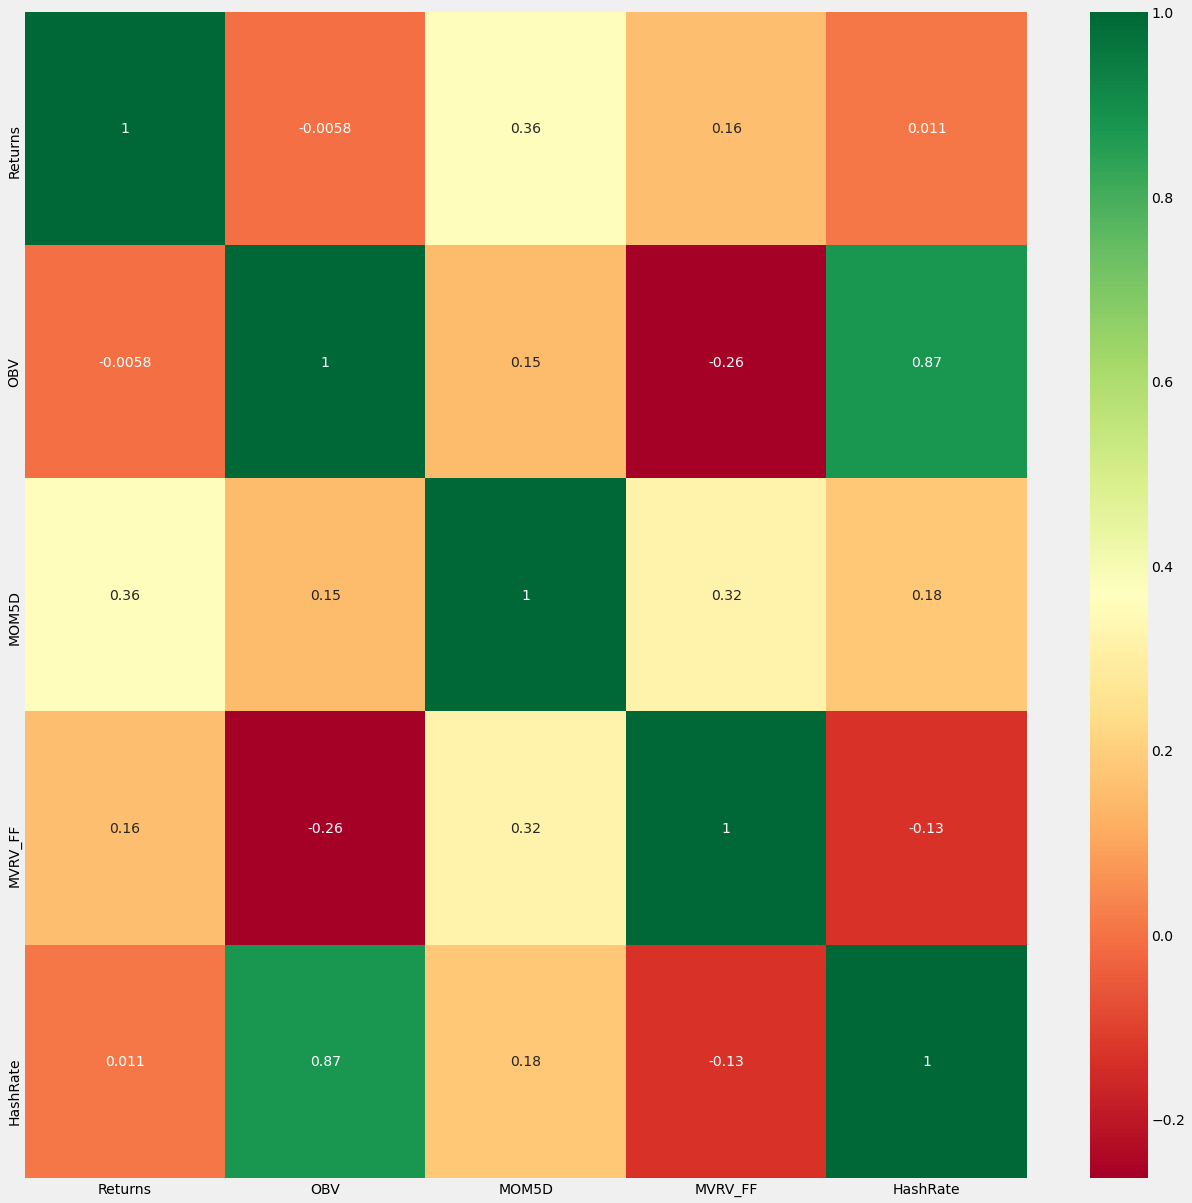

In [22]:
# Correlation Matrix with Heatmap
corrmat = X.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(X[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.show()

We can see the low correlation between the features.

#### Self Organizing Maps (SOM)
Self-organizing maps (SOM) are a class of unsupervised learning neural networks used for feature detection. SOM are used to project a high dimensional data into a smaller set and are used for dimensionality reduction.

SOMs differ from conventional artificial neural networks as they apply competitive learning when compared to error correlated learning, which involves backpropagation and gradient descent. In SOM, the training data has no labels and the map learns to differentiate and distinguish features based on similarities.

 [   471 / 10000 ]   5% - 0:00:04 left 

 [   914 / 10000 ]   9% - 0:00:03 left 

 [  1356 / 10000 ]  14% - 0:00:03 left 

 [  1804 / 10000 ]  18% - 0:00:03 left 

 [  2265 / 10000 ]  23% - 0:00:03 left 

 [  2721 / 10000 ]  27% - 0:00:03 left 

 [  3187 / 10000 ]  32% - 0:00:03 left 

 [  3632 / 10000 ]  36% - 0:00:02 left 

 [  4082 / 10000 ]  41% - 0:00:02 left 

 [  4546 / 10000 ]  45% - 0:00:02 left 

 [  4979 / 10000 ]  50% - 0:00:02 left 

 [  5453 / 10000 ]  55% - 0:00:02 left 

 [  5901 / 10000 ]  59% - 0:00:01 left 

 [  6354 / 10000 ]  64% - 0:00:01 left 

 [  6812 / 10000 ]  68% - 0:00:01 left 

 [  7249 / 10000 ]  72% - 0:00:01 left 

 [  7721 / 10000 ]  77% - 0:00:01 left 

 [  8179 / 10000 ]  82% - 0:00:00 left 

 [  8642 / 10000 ]  86% - 0:00:00 left 

 [  9111 / 10000 ]  91% - 0:00:00 left 

 [  9556 / 10000 ]  96% - 0:00:00 left 

 [  9998 / 10000 ] 100% - 0:00:00 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.27228361540784973


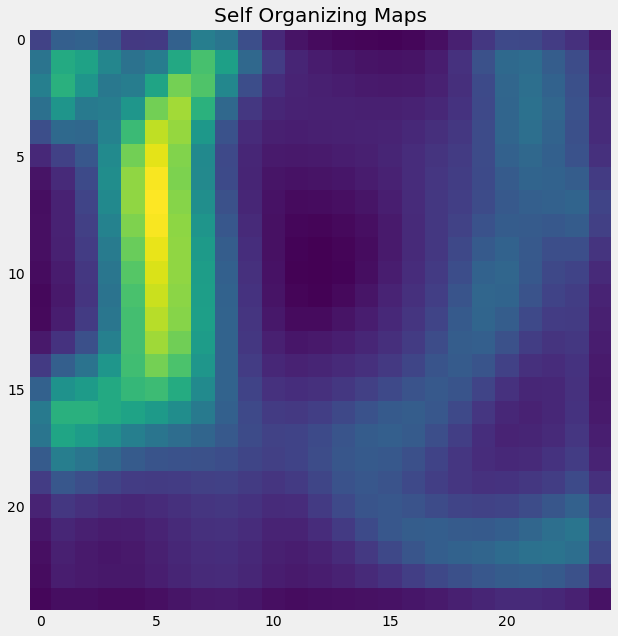

In [23]:
# SOM: basado en el lab de SOM y en https://github.com/JustGlowing/minisom/blob/master/examples/FeatureSelection.ipynb
# Import libraries
import pandas as pd
import numpy as np

# SOM & Sklearn library
from minisom import MiniSom  
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Visualization library
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
size = len(list(Bitcoin.keys()))
som = MiniSom(size, size, len(list(Bitcoin.keys())), learning_rate=0.5, sigma=5, random_seed=42) 

scaler = MinMaxScaler()
scaled_Bitcoin = scaler.fit_transform(Bitcoin)
# Initialize with randon weights 
som.random_weights_init(scaled_Bitcoin) 
# Trains SOM with 10000 iterations 
som.train_batch(scaled_Bitcoin,10000, verbose=True) 

# Plot SOM 
plt.figure(figsize=(20, 10)) 
for ix in range(len(scaled_Bitcoin)): 
	winner = som.winner(scaled_Bitcoin[ix]) 
	#plt.text(winner[0], winner[1],names[ix], bbox=dict(facecolor='white', alpha=0.5, lw=0))  
plt.imshow(som.distance_map()) 
plt.grid(False) 
plt.title('Self Organizing Maps') 
plt.show()

 [  1160 / 10000 ]  12% - 0:00:01 left 

 [  2311 / 10000 ]  23% - 0:00:01 left 

 [  3437 / 10000 ]  34% - 0:00:01 left 

 [  4554 / 10000 ]  46% - 0:00:00 left 

 [  5741 / 10000 ]  57% - 0:00:00 left 

 [  6856 / 10000 ]  69% - 0:00:00 left 

 [  7773 / 10000 ]  78% - 0:00:00 left 

 [  8909 / 10000 ]  89% - 0:00:00 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.4530395401751993


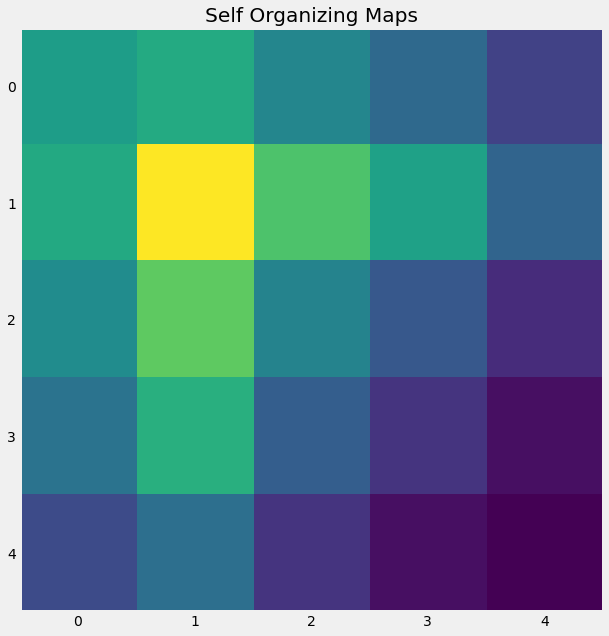

In [24]:
# SOM: basado en el lab de SOM y en https://github.com/JustGlowing/minisom/blob/master/examples/FeatureSelection.ipynb
# Import libraries
import pandas as pd
import numpy as np

# SOM & Sklearn library
from minisom import MiniSom  
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Visualization library
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
size = len(list(X.keys()))
som = MiniSom(size, size, len(list(X.keys())), learning_rate=0.5, sigma=5, random_seed=42) 

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
# Initialize with randon weights 
som.random_weights_init(scaled_X) 
# Trains SOM with 10000 iterations 
som.train_batch(scaled_X,10000, verbose=True) 

# Plot SOM 
plt.figure(figsize=(20, 10)) 
for ix in range(len(scaled_X)): 
	winner = som.winner(scaled_X[ix]) 
	#plt.text(winner[0], winner[1],names[ix], bbox=dict(facecolor='white', alpha=0.5, lw=0))  
plt.imshow(som.distance_map()) 
plt.grid(False) 
plt.title('Self Organizing Maps') 
plt.show()

### <font color= darkblue> Normalizing the Dataset
Feature scaling helps the algorithm in converging the local/global minimum efficiently. Different time periods of data have different value ranges and hence we scale/normalize the data. We choose to normalize features in order to avoid feature data:

- containing features with very large values
- that is heterogeneous: when different features are on completely different scales

Otherwise, there can be large gradient updates that prevent network convergence.


#### <font color= darkblue> Data Leakage</font>
Data leakage is when information from outside the training dataset is used to create the model. This additional information can allow the model to learn or know something that it otherwise would not know and in turn invalidate the estimated performance of the model being constructed.

We will use MinMaxScaler from Sci-kit Learn. https://scikitlearn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

#### <font color= darkblue>Spliting the data</font>
A critical part of any machine learning study is to have a clear distinction between the data that is used to train a model and the data used to evaluate the predictive power of the model out-of-sample. Therefore, we will split our data as follows

\begin{itemize}
\item train: 70\% of data will be used for training the models;
\item test: 30\% of data will be used to evaluate the performance of the models out-of-sample.
\end{itemize}

In [26]:
# 70% train/test split
split = int(len(X) * 0.7)

# We transform Y to a binary classification problem's values (0 y 1)
from sklearn.preprocessing import LabelEncoder 
encoder = LabelEncoder() 
encoder.fit(Y) 
encoded_Y = encoder.transform(Y) 
# We transform encoded_Y into a dataframe in order to use .iloc and being able to make the train/test split
Y = pd.DataFrame(encoded_Y, columns = ['Column_A']) 

# Create train data set
X_train, y_train = X.iloc[split:], Y.iloc[split:]
# Test data after train split
X_test, y_test = X.iloc[:split], Y.iloc[:split]


# Scale the features MinMax for training and test datasets
scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
#
X_train=scaled_X_train
X_test=scaled_X_test

ValueError: y should be a 1d array, got an array of shape (998, 24) instead.

#### Reshaping the Data
We need to reshape the data as LSTM and ALSTM networks consume input in a 3-dimensional array in the form of number of samples, number of time steps and number of features, while our x_train data is a 2-dimensional array.

In [ ]:
# Reshaping the Data for LSTM and ALSTM
# reshaping into 3D Array
X_train_LSTM=np.array(scaled_X_train).reshape(len(scaled_X_train),1,len(list(X.keys()))) # len(scaled_train_data) samples; 1 timesteps per sample; 9 features per timestep or 1 samples; len(scaled_train_data) timesteps; 9 features per timestep?
X_test_LSTM=np.array(scaled_X_test).reshape(len(scaled_X_test),1,len(list(X.keys())))

# check whether the next lines are neccesary
# y_train=np.array(y_train)
# y_test=np.array(y_test)

# <font color= darkblue> Part II:  Building Models</font> 

#### <font color= darkblue>Keras </font>
Keras is a deep learning API for Python and is one of the most powerful and easy to use library which runs on top of popular libraries like TensorFlow for creating deep learning models. In order to train and and test neural networks we will use the python package Keras which will use the tensorflow backend.

In [ ]:
import numpy as np
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import load_model, Model

### 1. Naive Bayes
The Naive Bayes method is a supervised learning algorithm based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB().fit(X_train, y_train)
print("score on test: " + str(mnb.score(X_test, y_test)))
print("score on train: "+ str(mnb.score(X_train, y_train)))

### 2. Logistic Regression
Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable. Mathematically, a binary logistic model has a dependent variable with two possible values, such as pass/fail which is represented by an indicator variable, where the two values are labeled "0" and "1". In the logistic model, the log-odds (the logarithm of the odds) for the value labeled "1" is a linear combination of one or more independent variables ("predictors"); the independent variables can each be a binary variable (two classes, coded by an indicator variable) or a continuous variable (any real value). The corresponding probability of the value labeled "1" can vary between 0 (certainly the value "0") and 1 (certainly the value "1"), hence the labeling; the function that converts log-odds to probability is the logistic function, hence the name. The unit of measurement for the log-odds scale is called a logit, from logistic unit, hence the alternative names.

In [ ]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print("score on test: " + str(lr.score(X_test, y_test)))
print("score on train: "+ str(lr.score(X_train, y_train)))

### 3. K-Nearest Neighbours
In k-NN classification, the output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor.

k-NN is a type of classification where the function is only approximated locally and all computation is deferred until function evaluation. Since this algorithm relies on distance for classification, if the features represent different physical units or come in vastly different scales then normalizing the training data can improve its accuracy dramatically.

A peculiarity of the k-NN algorithm is that it is sensitive to the local structure of the data.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
knn.fit(X_train, y_train)
print("train shape: " + str(X_train.shape))
print("score on test: " + str(knn.score(X_test, y_test)))
print("score on train: "+ str(knn.score(X_train, y_train)))

### 4. Support Vector Machine
Classifying data is a common task in machine learning. Suppose some given data points each belong to one of two classes, and the goal is to decide which class a new data point will be in. In the case of support-vector machines, a data point is viewed as a p-dimensional vector (a list of p numbers), and we want to know whether we can separate such points with a (p-1)-dimensional hyperplane. This is called a linear classifier. There are many hyperplanes that might classify the data. One reasonable choice as the best hyperplane is the one that represents the largest separation, or margin, between the two classes. So we choose the hyperplane so that the distance from it to the nearest data point on each side is maximized.

In [ ]:
from sklearn.svm import LinearSVC
svm=LinearSVC(C=100)
svm.fit(X_train, y_train)
print("score on test: " + str(svm.score(X_test, y_test)))
print("score on train: "+ str(svm.score(X_train, y_train)))

### 5. Decision Tree
A decision tree is a flowchart-like structure in which each internal node represents a "test" on an attribute (e.g. whether a coin flip comes up heads or tails), each branch represents the outcome of the test, and each leaf node represents a class label (decision taken after computing all attributes). The paths from root to leaf represent classification rules.
The decision tree can be linearized into decision rules, where the outcome is the contents of the leaf node, and the conditions along the path form a conjunction in the if clause. In general, the rules have the form:

if condition1 and condition2 and condition3 then outcome.

Decision rules can be generated by constructing association rules with the target variable on the right. They can also denote temporal or causal relations.

i.e. A Decision Tree is a non-parametric supervised learning method used for classification and regression which goal is to create a model that predicts the value of a target variable by learning simple decision rules (if-else) inferred from the data features.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
print("score on test: "  + str(clf.score(X_test, y_test)))
print("score on train: " + str(clf.score(X_train, y_train)))

Applying a single decision tree to this feature rich dataset leads to massive overfitting. Indeed, an accuracy of 100% means it has remembered exactly the training dataset and is therefore generalising poorly on the test data. What we can see here is one of the cons of single decision tree which can’t handle data with too many features.

However, this issue can be addressed by either tuning some parameter of the algorithm or introducing ensemble learning techniques. Here you can find an in-depth article about parameter tuning of the decision tree classifier: https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3. Next we will focus on some common ensemble learning approaches.

### 6. Bagging Decision Tree (Ensemble Learning I)
Bootstrap aggregating, also called bagging (from bootstrap aggregating), is a machine learning ensemble meta-algorithm designed to improve the stability and accuracy of machine learning algorithms used in statistical classification and regression. It also reduces variance and helps to avoid overfitting. 

When a decision tree overfits, applying an ensemble learning algorithm like bagging might improve the quality of the prediction model. 

In bagging, the training data is increased by taking bootstraps from the training data. This means multiple samples are taken (with replacement) from the training data and the model is trained on these sub-datasets. The final prediction is the average over all predictions from each bootstrap sample.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
# max_samples: maximum size 0.5=50% of each sample taken from the full dataset
# max_features: maximum of features 1=100% taken here all 10K 
# n_estimators: number of decision trees 
bg=BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10)
bg.fit(X_train, y_train)
print("score on test: " + str(bg.score(X_test, y_test)))
print("score on train: "+ str(bg.score(X_train, y_train)))

### 7. Boosting Decision Tree (Ensemble Learning II)
In machine learning, boosting is an ensemble meta-algorithm for primarily reducing bias, and also variance in supervised learning, and a family of machine learning algorithms that convert weak learners to strong ones.

"Can a set of weak learners create a single strong learner?" [Kearns and Valiant (1988, 1989)] 

A weak learner is defined to be a classifier that is only slightly correlated with the true classification (it can label examples better than random guessing). In contrast, a strong learner is a classifier that is arbitrarily well-correlated with the true classification.

While boosting is not algorithmically constrained, most boosting algorithms consist of iteratively learning weak classifiers with respect to a distribution and adding them to a final strong classifier. When they are added, they are weighted in a way that is related to the weak learners' accuracy. After a weak learner is added, the data weights are readjusted, known as "re-weighting". Misclassified input data gain a higher weight and examples that are classified correctly lose weight. Thus, future weak learners focus more on the examples that previous weak learners misclassified.

In general, we can’t use Boosting to improve a completely overfitted model with score = 1. To apply Boosting, we first have to tweak the decision tree classifier a bit. It took me some trial and error until I got the best parameters for the Decision Tree and the AdaBoost Classifier.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
adb = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=4),n_estimators=10,learning_rate=0.6)
adb.fit(X_train, y_train)
print("score on test: " + str(adb.score(X_test, y_test)))
print("score on train: "+ str(adb.score(X_train, y_train)))

### 8. Random Forest (Ensemble Learning III)
Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees.

ie. the Random Forest classifier is basically a modified bagging algorithm of a Decision Tree that selects the subsets differently. We found out that max_depth=9 is a good value for this feature-rich dataset.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# n_estimators = number of decision trees
rf = RandomForestClassifier(n_estimators=30, max_depth=9)
rf.fit(X_train, y_train)
print("score on test: " + str(rf.score(X_test, y_test)))
print("score on train: "+ str(rf.score(X_train, y_train)))

### 9. Voting Classifier (Ensemble Learning IV)
This classifier from the ensemble learning toolbox evaluates different classifiers and selects the best out of it.

The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities to predict the class labels. Such a classifier can be useful for a set of equally well performing models in order to balance out their individual weaknesses

So let’s use this classifier to combine some of the models we had so far and apply the Voting Classifier on
\begin{itemize}
\item Naive Bayes (84%, 2s);
\item Logistic Regression (86%, 60s, overfitting);
\item Random Forest (80%, 20s);
\item Support Vector Machine (85%, 10s).
\end{itemize}
Be aware that for this code snippet, all used model definitions have to be loaded in the Python kernel.

In [ ]:
from sklearn.ensemble import VotingClassifier
# 1) naive bias = mnb
# 2) logistic regression =lr
# 3) random forest =rf
# 4) support vector machine = svm
evc=VotingClassifier(estimators=[('mnb',mnb),('lr',lr),('rf',rf),('svm',svm)],voting='hard')
evc.fit(X_train, y_train)
print("score on test: " + str(evc.score(X_test, y_test)))
print("score on train: "+ str(evc.score(X_train, y_train)))

### 10. PPR
Projection pursuit regression (PPR) is a statistical model developed by Jerome H. Friedman and Werner Stuetzle which is an extension of additive models. This model adapts the additive models in that it first projects the data matrix of explanatory variables in the optimal direction before applying smoothing functions to these explanatory variables.

The model consists of linear combinations of ridge functions: non-linear transformations of linear combinations of the explanatory variables.

For a given set of data $\{(y_{i},x_{i})\}_{i=1}^{n}\}$, the goal is to minimize the error function

$$\min _{f_{j},\beta _{j}}S=\sum _{i=1}^{n}\left[y_{i}-\sum _{j=1}^{r}f_{j}(\beta _{j}^{\mathrm {T} }x_{i})\right]^{2}$$

over the functions $f_{j}$ and vectors $\beta _{j}$. 

Previously-fitted pairs can be readjusted after new fit-pairs are determined by an algorithm known as backfitting, which entails reconsidering a previous pair, recalculating the residual given how other pairs have changed, refitting to account for that new information, and then cycling through all fit-pairs this way until parameters converge.

The PPR model is a universal estimator, as it can approximate any continuous function in $\mathbb{R}^p$.

In [ ]:
from skpp import ProjectionPursuitRegressor
from skpp import ProjectionPursuitClassifier
import keras
# r: The number of terms in the underlying additive model. The input will be put through r projections, r functions of those projections, and then multiplication by r output vectors to determine output.
#ppr = ProjectionPursuitRegressor(r=10)
ppr = ProjectionPursuitClassifier(r=10)
fit=ppr.fit(X_train, y_train)
ppr_prediction=ppr.predict(X_test)

In [ ]:
import sklearn
ppr_accuracy=sklearn.metrics.accuracy_score(y_test,ppr_prediction)
ppr_cross_entropy_loss=sklearn.metrics.log_loss(y_test, ppr_prediction)
ppr_zero_one_loss=sklearn.metrics.zero_one_loss(y_test,ppr_prediction)
print('MLP: [accuracy, crossentropy loss, zero/one loss] =', [ppr_accuracy,ppr_cross_entropy_loss, ppr_zero_one_loss])

### 11. Neural Network and Deep Learning
We assume the reader has basic notions of neural networks as this projects' intention is to just show the application of different statistical models. We will just mention that deep learning uses an artificial neural network that uses multiple layers to progressively extract higher level features from the training data. 

First of all, we will use a simple three-layer network without any optimisation, except the usage of a small validation dataset. Here we are using Keras instead of Sklearn.

In [ ]:
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras import metrics
model=models.Sequential()
model.add(layers.Dense(16,activation='relu',input_shape = (X_train.shape[0],X_train.shape[1])))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
# 0.33 validation dataset
model.fit(X_train,y_train,epochs=4,batch_size=512,validation_split=0.33)
print("score on test: " + str(model.evaluate(X_test,y_test)[1]))
print("score on train: "+ str(model.evaluate(X_train,y_train)[1]))

Using a neural network leads to the best test score that we achieved so far, at around 88%. However, the standard settings lead to an overfitting of the training data.

This issue can be handled easily by adding some minor tuning parameters which reduce the training score to 0.90.
In the following, I applied the 3 best practices for handling overfitting in a neural network:

\begin{itemize}
\item reduce the network’s size;
\item adding some weight regularisation;
\item adding dropout.
\end{itemize}

In [ ]:
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras import regularizers
from keras import metrics
model=models.Sequential()
model.add(layers.Dense(8,kernel_regularizer=regularizers.l2(0.003),activation='relu',input_shape=(X_train.shape[0],X_train.shape[1])))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8,kernel_regularizer=regularizers.l2(0.003),activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,epochs=4,batch_size=512,validation_split=0.33)
print("score on test: " + str(model.evaluate(X_test,y_test)[1]))
print("score on train: "+ str(model.evaluate(X_train,y_train)[1]))

Next, we will use three types of neural networks: MLP (multi-layer perceptron), LSTM and ALSTM.

#### MLP
An MLP consists of at least three layers of nodes: an input layer, a hidden layer and an output layer. Except for the input nodes, each node is a neuron that uses a nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training. Its multiple layers and non-linear activation distinguish MLP from a linear perceptron. It can distinguish data that is not linearly separable.

We define a function to build the model in Keras with a specified number of hidden layers, each with a specified number of neurons. The function returns the compiled model. The edge of the code presented below is the possibility of easily implement any change that need to be done without re-writing entire bits of the code script. 

In [ ]:
# MLP: mirar https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/ + https://scikit-learn.org/stable/modules/neural_networks_supervised.html
# define model

def model_MLP(optimizer,activation,loss,metrics):
  model = Sequential()

  model.add(Dense(64,  activation = activation))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  return model

MLP=model_MLP(optimizer='adam',activation='relu',loss='binary_crossentropy',metrics=['binary_accuracy'])  

#### <font color= darkblue> Fitting the Model</font>

The classic Stochastic gradient descent (SGD) method has been enhanced by various adaptive moment estimation (ADAM) techniques that build on AdaGrad and RMSProp \& others. There is also some *Practical Advice for Building Deep Neural Networks* by Matt H and Daniel R that explains why the ADAM optimiser, ReLU activation function and variance scaled initialisation are preferred.
 
 In fact, while Stochastic Gradient Descent is used in many Neural Network problems, it has the problem of converging to a local minimum. This of course presents a problem considering Bitcoin price. Some other nice optimizers are variations of adaptive learning algorithms, like Adam, Adagrad, and RMSProp. Adam was found to work slightly better than the rest.

In [ ]:
history_MLP=MLP.fit(np.array(X_train), y_train, batch_size=len(X_train), epochs=200, verbose=2, validation_split=0.33, shuffle=False)

In [ ]:
print(MLP.summary())

### LSTM

### <font color= darkblue>Building an LSTM Model </font>

In buiding neural networks, we would be cautious on deploying too many neurons/layers, especially if the data set is not particularly large. While in-sample fit will inevitably increase, too many parameters increases the risk of overfitting. Additionally, the training (optimization) process becomes much more computationally intensive and the risk of non-convergence increases.  

One important point to consider is the fact that when training with noisy data (such as financial time-series) it is important to build a Neural Network that is not excessively complex, or uses other mechanisms such as drop-out, to help avoid over-fitting.

#### <font color= darkblue> Define Model
A neural network is made up of two parts. The choice of the number of neurons, hidden layers, and activation functions determines how $x$ variables are transformed into $y$, given some fixed weights. The transformation process is known as the
forward propagation step.

First, we define the LSTM Recurrent Neural Network by initializing the Sequential Model. We'll add more LSTM layers and adjust the Dropout in order to improve the accuracy of our model. Finally, a Dense layer is used as output layer.

Next, we compile and train the model defined below. Iteratively, we can increase or decrease the epochs and batch size to get more accuracy.

#### <font color= darkblue> LSTM Model Creation </font>

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points (such as images), but also entire sequences of data (such as speech or video).

A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.

LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series. LSTMs were developed to deal with the vanishing gradient problem that can be encountered when training traditional RNNs.

As with the previous model we define a function to build a LSTM model. In this case we add a dropout percentage (drop_pct) which is a regularization method that adds information in order to solve an ill-posed problem or to prevent overfitting.

In [ ]:
def model_LSTM_(optimizer,activation,loss,metrics):
  model = Sequential()

  model.add(LSTM(units=256, input_shape = (X_train_LSTM.shape[1],X_train_LSTM.shape[2]), return_sequences=True)) 
  model.add(Dropout(0.4, seed=seed_value))

  model.add(LSTM(units=256, return_sequences=True))
  model.add(Dropout(0.4, seed=seed_value))

  model.add(LSTM(units=64, return_sequences=False))
  model.add(Dropout(0.4, seed=seed_value))

  model.add(Dense(64,  activation = activation))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  return model

# Define the Model
model_LSTM=model_LSTM_(optimizer='adam',activation='relu',loss='binary_crossentropy',metrics=['binary_accuracy'])

In [ ]:
history_LSTM=model_LSTM.fit(X_train_LSTM, y_train, batch_size=len(X_train_LSTM), epochs=200, verbose=2, validation_split=0.33, shuffle=False)

In [ ]:
print(model_LSTM.summary())

### ALSTM

In [ ]:
#from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM
#from tensorflow.keras.models import load_model, Model
from attention import Attention
def model_ALSTM(optimizer,activation,loss,metrics):
  model = Sequential()

  model.add(LSTM(units=256, input_shape = (X_train_LSTM.shape[1],X_train_LSTM.shape[2]), return_sequences=True)) 
  model.add(Dropout(0.4, seed=seed_value))

  model.add(Attention(128))

  # model.add(LSTM(units=256, return_sequences=True))
  # model.add(Dropout(0.4, seed=seed_value))

  # model.add(LSTM(units=64, return_sequences=False))
  # model.add(Dropout(0.4, seed=seed_value))

  model.add(Dense(64,  activation = activation))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  return model

# Define the Model
ALSTM=model_ALSTM(optimizer='adam',activation='relu',loss='binary_crossentropy',metrics=['binary_accuracy'])  
history_ALSTM=ALSTM.fit(X_train_LSTM, y_train, batch_size=len(X_train_LSTM), epochs=200, verbose=2, validation_split=0.33, shuffle=False)

In [ ]:
print(ALSTM.summary())

### Visualize the training and validation loss

In [ ]:
# MLP
fig, axs = plt.subplots(1,2)
fig.suptitle('MLP model training performance', fontsize=20)
axs[0].plot(history_MLP.history['binary_accuracy'])
axs[0].plot(history_MLP.history['val_binary_accuracy'])
axs[0].set_title('Model accuracy', fontsize=15)
axs[0].set_ylabel('binary_accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper left')
axs[1].plot(history_MLP.history['loss'])
axs[1].plot(history_MLP.history['val_loss'])
axs[1].set_title('Model loss', fontsize=15)
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# LSTM
fig, axs = plt.subplots(1,2)
fig.suptitle('LSTM model training performance', fontsize=20)
axs[0].plot(history_LSTM.history['binary_accuracy'])
axs[0].plot(history_LSTM.history['val_binary_accuracy'])
axs[0].set_title('Model accuracy', fontsize=15)
axs[0].set_ylabel('binary_accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper left')
axs[1].plot(history_LSTM.history['loss'])
axs[1].plot(history_LSTM.history['val_loss'])
axs[1].set_title('Model loss', fontsize=15)
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# ALSTM
fig, axs = plt.subplots(1,2)
fig.suptitle('ALSTM model training performance', fontsize=20)
axs[0].plot(history_ALSTM.history['binary_accuracy'])
axs[0].plot(history_ALSTM.history['val_binary_accuracy'])
axs[0].set_title('Model accuracy', fontsize=15)
axs[0].set_ylabel('binary_accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper left')
axs[1].plot(history_ALSTM.history['loss'])
axs[1].plot(history_ALSTM.history['val_loss'])
axs[1].set_title('Model loss', fontsize=15)
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper left')
plt.show()

### Prediction
Now that the model is trained, it needs to be tested on the test dataset. We used Root Square Mean Error (RMSE), which is a frequently used measure of the differences between actual values and forecast values.

In [ ]:
# MLP
y_pred_proba_MLP=MLP.predict_proba(X_test, batch_size=1)
# LSTM
y_pred_proba_LSTM=model_LSTM.predict_proba(X_test_LSTM, batch_size=1)
# ALSTM
y_pred_proba_ALSTM=ALSTM.predict_proba(X_test_LSTM, batch_size=1)

#### Prediction metrics on the test set

In [ ]:
# MLP
results_MLP=MLP.evaluate(X_test, y_test)
print('MLP: [binary_crossentropy, binary_accuracy] =', results_MLP)

In [ ]:
# LSTM
results_LSTM=model_LSTM.evaluate(X_test_LSTM, y_test)
print('LSTM: [binary_crossentropy, binary_accuracy] =', results_LSTM)

In [ ]:
# ALSTM
results_ALSTM=ALSTM.evaluate(X_test_LSTM, y_test)
print('ALSTM: [binary_crossentropy, binary_accuracy] =', results_ALSTM)

#### ROCs Curves

In [ ]:
# MLP
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
lr_probs = y_pred_proba_MLP
#lr_probs = model.predict_proba(X_train)
ns_probs = [0 for _ in range(len(y_test))]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LSTM: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='LSTM')
plt.title('MLP ROC Curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.savefig('ROC.png')
plt.show()

In [ ]:
# LSTM
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
lr_probs = y_pred_proba_LSTM
#lr_probs = model.predict_proba(X_train)
ns_probs = [0 for _ in range(len(y_test))]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LSTM: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='LSTM')
plt.title('LSTM ROC Curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.savefig('ROC.png')
plt.show()

In [ ]:
# ALSTM
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
lr_probs = y_pred_proba_ALSTM
#lr_probs = model.predict_proba(X_train)
ns_probs = [0 for _ in range(len(y_test))]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LSTM: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='LSTM')
plt.title('ALSTM ROC Curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.savefig('ROC.png')
plt.show()

### Summary
We now trained 10 different machine learning algorithms on the same dataset to solve the same task, predicting a positive or negative review based on a sentiment analysis of text passages. So let’s see who wins in terms of the quality of the prediction and in run time. The parameter overfitting (OF) is just the difference from train score to test score. If it is large, it means we have high overfitting. COMPLETAR CON LA TABLA

#### Best Runtime:
In terms of Runtime, the fastest algorithms are Naive Bayes, Support Vector Machine, Voting Classifier and the Neural Network.

#### Best Prediction Score:
In terms of the best prediction of the test dataset, the best algorithms are Logistic Regression, Voting Classifier and Neural Network.

#### Worst Overfitting:
The algorithms that are overfitting the most are Logistic Regression, K-Nearest Neighbours, Decision Tree and Bagging Decision Tree.

#### Best Algorithm:
The overall best approach to solve this text sentiment analysis task is the Neural Network, which is fast, has high accuracy and low overfitting. A little bit faster but a bit worse in prediction quality is the Voting Classifier.

#### Predicción vs Realidad
TERMINAR Y ARREGLAR EL ALGO

In [ ]:
# Plot pred vs actual
# LSTM
C=[]
for b in y_pred_proba_LSTM:
  if(b[0]>=0.5):
    C.append(1)
  else:
    C.append(0)
daily_returns = X[:len(X_test_LSTM)]['Returns']
strategy = daily_returns * C
# Plot the cumulative daily returns (pred vs actual) 
strategy.cumsum().plot(color='red')
daily_returns.cumsum().plot(color='green')
plt.show()